**Download the Jena Climate data zip file from the AWS S3 Bucket to Colab.**

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2024-04-09 00:38:54--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.121.32, 52.216.208.128, 52.217.235.64, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.121.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  39.3MB/s    in 0.3s    

2024-04-09 00:38:55 (39.3 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



**Extracting a Zip File in Google Colab**

In [2]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Analyzing the Data of the Jena Weather Dataset**



In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("All Variables:", num_variables)
num_rows = len(lines)
print("All Rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
All Variables: 15
All Rows: 420451


We have total records 420,551 and 14 weather-related values


**Parse the data**

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Temperature timeseries Plot**

Text(0, 0.5, 'Temperature')

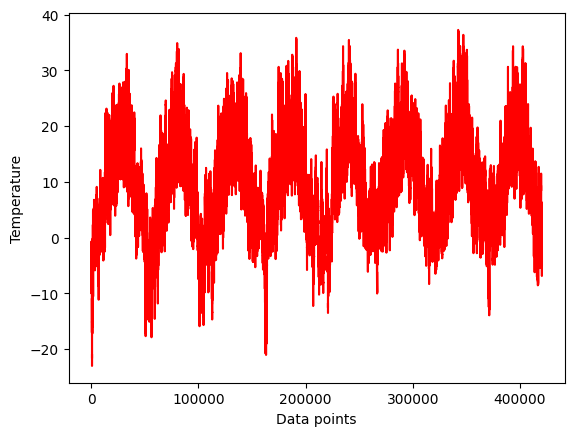

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature, color='red')
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Plotting the temperature timeseries for first ten days**

It seems data recorded every 10 minutes, so we get 24 × 6 = 144 data points per day. so one day data has 144 data points hence 10 days will have 1440 data points

Text(0, 0.5, 'Temperature')

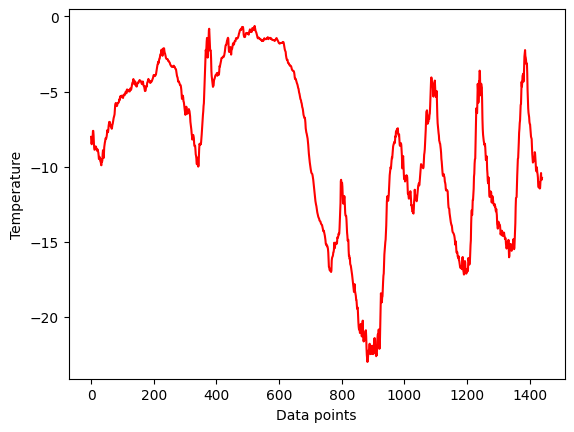

In [6]:
plt.plot(range(1440), temperature[:1440], color='red')
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Splitting Dataset into Train, Validation, and Test Sets**

we'll use for each data split- 50% for Train, 25%- validation

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("number_of_train_spls:", num_train_samples)
print("number_of_validation_spls:", num_val_samples)
print("number_of_test_spls:", num_test_samples)

number_of_train_spls: 210225
number_of_validation_spls: 105112
number_of_test_spls: 105114


### **Preparing the data**

Normalising the data: Vectorization is not required because the data is already in a numerical representation. Nonetheless, it is advised to standardise all variables because the data scales vary amongst them, with temperature ranging from -20 to +30 and pressure measured in millibars.

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Creating datasets for testing, validation, and training is necessary because the dataset's samples are largely duplicated. Thus, explicitly allocating memory for every sample would be inefficient. Rather, we shall produce the samples in real time.

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Examining the results of one of our databases**

In [11]:
for samples, targets in train_dataset:
    print("shape of the sample:", samples.shape)
    print("shape of the targets:", targets.shape)
    break

shape of the sample: (256, 120, 14)
shape of the targets: (256,)


### **A common-sense, non-machine-learning baseline**

Calculating the sensible baseline MAE - The "evaluate_naive_method" defined function offers a starting point for assessing the effectiveness of a straightforward forecasting technique that uses the final value in the input sequence to predict the value that will come after it..

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

mae_validation = evaluate_naive_method(val_dataset)
mae_test = evaluate_naive_method(test_dataset)

print(f"MAE_Validation: {mae_validation:.2f}")
print(f"MAE_Test: {mae_test:.2f}")


MAE_Validation: 2.44
MAE_Test: 2.62


A sensible baseline method would be to forecast that the temperature in the next 24 hours will be the same as it is now. The validation MAE (Mean Absolute Error) using the simple baseline is 2.44 degrees Celsius, while the test MAE is 2.62 degrees Celsius. Put another way, an average variation of roughly 2.5 degrees would arise from assuming that the temperature in the future stays the same as it is now..

### **Dense Layer-Basic Machine learning Model**

---



**Building and assessing a densely connected model**

In [13]:
from tensorflow import keras

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(16, activation="relu")(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 9s 11ms/step - loss: 13.2607 - mae: 2.8115 - val_loss: 10.3569 - val_mae: 2.5262
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 9.2472 - mae: 2.3870 - val_loss: 10.4223 - val_mae: 2.5421
Epoch 3/10
819/819 [==============================] - 9s 11ms/step - loss: 8.4200 - mae: 2.2807 - val_loss: 12.1685 - val_mae: 2.7723
Epoch 4/10
819/819 [==============================] - 9s 11ms/step - loss: 7.9183 - mae: 2.2155 - val_loss: 10.8335 - val_mae: 2.6020
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 7.5809 - mae: 2.1709 - val_loss: 10.7345 - val_mae: 2.5863
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 7.3181 - mae: 2.1351 - val_loss: 11.1505 - val_mae: 2.6519
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 7.1297 - mae: 2.1087 - val_loss: 13.6256 - val_mae: 2.9395
Epoch 8/10
819/819 [==============================] - 10s 12m

In [14]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 3s 8ms/step - loss: 11.2753 - mae: 2.6367
Test_MAE: 2.64


**Results Plot**

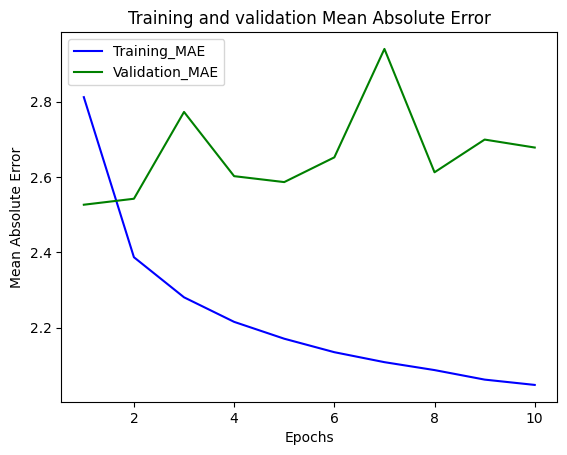

In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="green",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

### **1D convolutional model**

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.Conv1D(8, 24, activation="relu")(inputs)
x = keras.layers.MaxPooling1D(2)(x)
x = keras.layers.Conv1D(8, 12, activation="relu")(x)
x = keras.layers.MaxPooling1D(2)(x)
x = keras.layers.Conv1D(8, 6, activation="relu")(x)
x = keras.layers.GlobalAveragePooling1D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 17ms/step - loss: 22.5888 - mae: 3.7066 - val_loss: 14.7124 - val_mae: 3.0374
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 15.3704 - mae: 3.1209 - val_loss: 15.6505 - val_mae: 3.1357
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 14.2633 - mae: 2.9960 - val_loss: 14.8951 - val_mae: 3.0554
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 13.4250 - mae: 2.8969 - val_loss: 18.2491 - val_mae: 3.3821
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 12.8516 - mae: 2.8329 - val_loss: 14.7320 - val_mae: 3.0214
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 12.3698 - mae: 2.7769 - val_loss: 18.1375 - val_mae: 3.3490
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 11.9520 - mae: 2.7302 - val_loss: 16.3508 - val_mae: 3.1990
Epoch 8/10
819/819 [============================

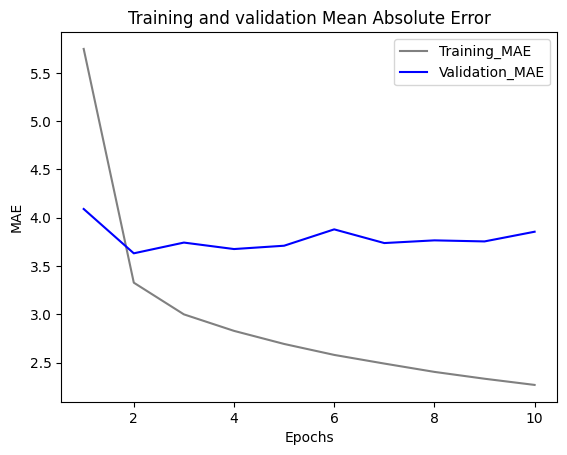

In [41]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

*It seems that the convolutional data performed poor compared to common sense or dense model. This could be because*

*- The assumption of translation invariance does not hold well for weather data.*

*- The order of the data is crucial. Recent past data is significantly more informative for predicting the temperature of the following day compared to data from several days ago. Unfortunately, a 1D convolutional neural network is unable to effectively capture this critical temporal order.*






**RNN**

### **1.A layer of an RNN capable of handling any length of sequence**

In [18]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = keras.layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 21s 24ms/step - loss: 138.4449 - mae: 9.6785 - val_loss: 143.9961 - val_mae: 9.8981
Epoch 2/10
819/819 [==============================] - 19s 23ms/step - loss: 136.3962 - mae: 9.5644 - val_loss: 143.9101 - val_mae: 9.8926
Epoch 3/10
819/819 [==============================] - 19s 23ms/step - loss: 136.3049 - mae: 9.5567 - val_loss: 143.7088 - val_mae: 9.8691
Epoch 4/10
819/819 [==============================] - 20s 24ms/step - loss: 136.2215 - mae: 9.5496 - val_loss: 143.6588 - val_mae: 9.8668
Epoch 5/10
819/819 [==============================] - 20s 24ms/step - loss: 136.1862 - mae: 9.5456 - val_loss: 143.6379 - val_mae: 9.8670
Epoch 6/10
819/819 [==============================] - 20s 24ms/step - loss: 136.1390 - mae: 9.5375 - val_loss: 143.5360 - val_mae: 9.8509
Epoch 7/10
819/819 [==============================] - 20s 24ms/step - loss: 136.0998 - mae: 9.5320 - val_loss: 143.5345 - val_mae: 9.8508
Epoch 8/10
819/819 [==============

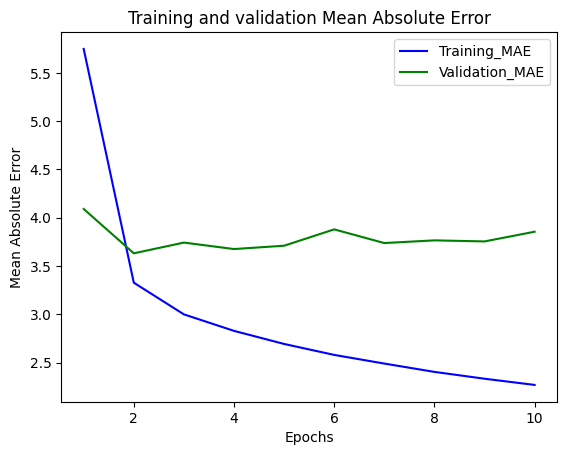

In [42]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="green",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

### **Stacking RNN layers using simple RNN**

In [19]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = keras.layers.SimpleRNN(16, return_sequences=True)(inputs)
x = keras.layers.SimpleRNN(16, return_sequences=True)(x)
outputs = keras.layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 63s 74ms/step - loss: 136.8163 - mae: 9.5618 - val_loss: 143.4179 - val_mae: 9.8379
Epoch 2/10
819/819 [==============================] - 61s 75ms/step - loss: 135.9514 - mae: 9.5115 - val_loss: 143.4153 - val_mae: 9.8362
Epoch 3/10
819/819 [==============================] - 60s 74ms/step - loss: 135.9155 - mae: 9.5070 - val_loss: 143.3902 - val_mae: 9.8328
Epoch 4/10
819/819 [==============================] - 60s 74ms/step - loss: 135.8959 - mae: 9.5049 - val_loss: 143.3871 - val_mae: 9.8313
Epoch 5/10
819/819 [==============================] - 60s 73ms/step - loss: 135.8820 - mae: 9.5030 - val_loss: 143.4098 - val_mae: 9.8334
Epoch 6/10
819/819 [==============================] - 61s 75ms/step - loss: 135.8752 - mae: 9.5016 - val_loss: 143.3938 - val_mae: 9.8310
Epoch 7/10
819/819 [==============================] - 60s 73ms/step - loss: 135.8657 - mae: 9.5006 - val_loss: 143.4055 - val_mae: 9.8308
Epoch 8/10
819/819 [==============

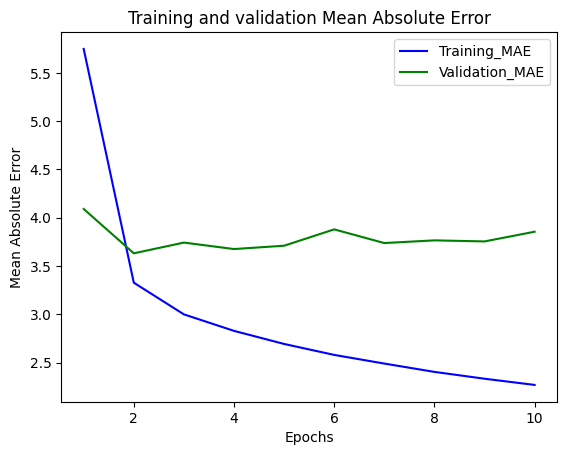

In [43]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="green",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

## **GRU (Gated Recurrent Unit)-Simple Method**

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.GRU(16)(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 57ms/step - loss: 33.0378 - mae: 4.1631 - val_loss: 11.1635 - val_mae: 2.5463
Epoch 2/10
819/819 [==============================] - 44s 54ms/step - loss: 10.4401 - mae: 2.5169 - val_loss: 9.7950 - val_mae: 2.4143
Epoch 3/10
819/819 [==============================] - 48s 59ms/step - loss: 9.8388 - mae: 2.4452 - val_loss: 10.1341 - val_mae: 2.4421
Epoch 4/10
819/819 [==============================] - 44s 54ms/step - loss: 9.5760 - mae: 2.4118 - val_loss: 10.3400 - val_mae: 2.4498
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 9.2809 - mae: 2.3767 - val_loss: 9.8103 - val_mae: 2.4051
Epoch 6/10
819/819 [==============================] - 45s 55ms/step - loss: 9.0098 - mae: 2.3439 - val_loss: 9.4826 - val_mae: 2.3702
Epoch 7/10
819/819 [==============================] - 47s 58ms/step - loss: 8.7656 - mae: 2.3140 - val_loss: 9.6233 - val_mae: 2.3856
Epoch 8/10
819/819 [==============================] - 43s

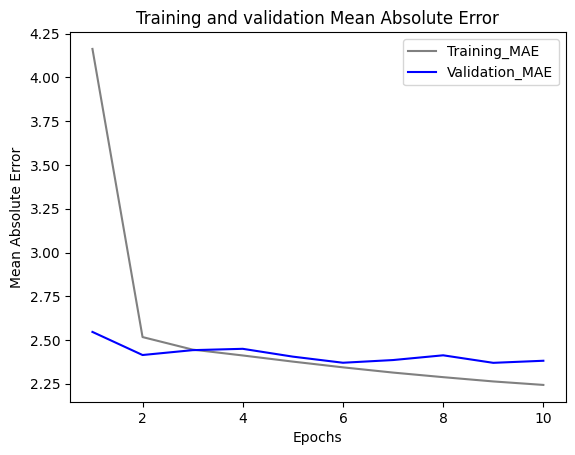

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

## **LSTM(Long Short-Term Memory )**

### **1.LSTM-Simple**

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(16)(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 50s 59ms/step - loss: 39.9635 - mae: 4.5849 - val_loss: 12.3507 - val_mae: 2.6803
Epoch 2/10
819/819 [==============================] - 50s 61ms/step - loss: 10.8096 - mae: 2.5588 - val_loss: 9.5515 - val_mae: 2.3999
Epoch 3/10
819/819 [==============================] - 48s 58ms/step - loss: 9.5920 - mae: 2.4171 - val_loss: 9.4138 - val_mae: 2.3802
Epoch 4/10
819/819 [==============================] - 48s 59ms/step - loss: 9.0871 - mae: 2.3499 - val_loss: 9.4367 - val_mae: 2.3949
Epoch 5/10
819/819 [==============================] - 50s 61ms/step - loss: 8.6894 - mae: 2.2960 - val_loss: 9.4691 - val_mae: 2.4000
Epoch 6/10
819/819 [==============================] - 47s 58ms/step - loss: 8.4110 - mae: 2.2632 - val_loss: 9.6425 - val_mae: 2.4198
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 8.1811 - mae: 2.2336 - val_loss: 9.9077 - val_mae: 2.4531
Epoch 8/10
819/819 [==============================] - 48s 5

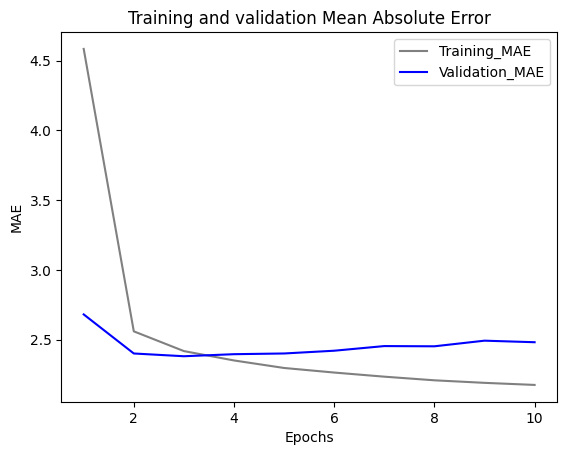

In [23]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **2.LSTM(Dropout Regularization)**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 67s 79ms/step - loss: 46.1082 - mae: 5.0625 - val_loss: 12.6748 - val_mae: 2.6905
Epoch 2/10
819/819 [==============================] - 63s 77ms/step - loss: 19.9567 - mae: 3.4226 - val_loss: 9.9222 - val_mae: 2.4530
Epoch 3/10
819/819 [==============================] - 66s 80ms/step - loss: 18.3683 - mae: 3.2945 - val_loss: 9.5868 - val_mae: 2.4121
Epoch 4/10
819/819 [==============================] - 64s 78ms/step - loss: 17.3159 - mae: 3.2010 - val_loss: 9.1734 - val_mae: 2.3543
Epoch 5/10
819/819 [==============================] - 62s 75ms/step - loss: 16.6713 - mae: 3.1379 - val_loss: 9.1958 - val_mae: 2.3630
Epoch 6/10
819/819 [==============================] - 64s 78ms/step - loss: 16.1835 - mae: 3.0920 - val_loss: 8.8091 - val_mae: 2.3051
Epoch 7/10
819/819 [==============================] - 64s 78ms/step - loss: 15.6887 - mae: 3.0489 - val_loss: 9.3954 - val_mae: 2.3893
Epoch 8/10
819/819 [==============================] - 

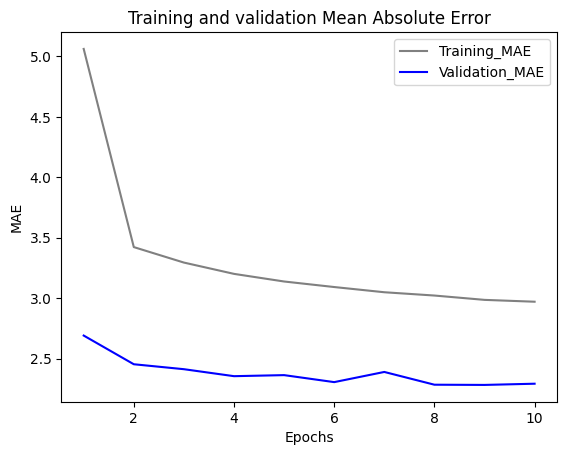

In [25]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **3.LSTM - Stacked(16 units)**

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(16, return_sequences=True)(inputs)
x = keras.layers.LSTM(16)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 98s 116ms/step - loss: 48.8649 - mae: 5.1302 - val_loss: 14.6354 - val_mae: 2.8489
Epoch 2/10
819/819 [==============================] - 97s 118ms/step - loss: 10.6596 - mae: 2.5252 - val_loss: 10.3595 - val_mae: 2.5070
Epoch 3/10
819/819 [==============================] - 97s 118ms/step - loss: 8.7903 - mae: 2.3156 - val_loss: 9.7403 - val_mae: 2.4229
Epoch 4/10
819/819 [==============================] - 100s 122ms/step - loss: 8.1239 - mae: 2.2231 - val_loss: 10.9093 - val_mae: 2.5685
Epoch 5/10
819/819 [==============================] - 98s 120ms/step - loss: 7.6348 - mae: 2.1540 - val_loss: 10.3143 - val_mae: 2.5064
Epoch 6/10
819/819 [==============================] - 94s 115ms/step - loss: 7.2963 - mae: 2.1055 - val_loss: 10.9695 - val_mae: 2.5802
Epoch 7/10
819/819 [==============================] - 94s 115ms/step - loss: 6.9544 - mae: 2.0565 - val_loss: 11.5810 - val_mae: 2.6534
Epoch 8/10
819/819 [==========================

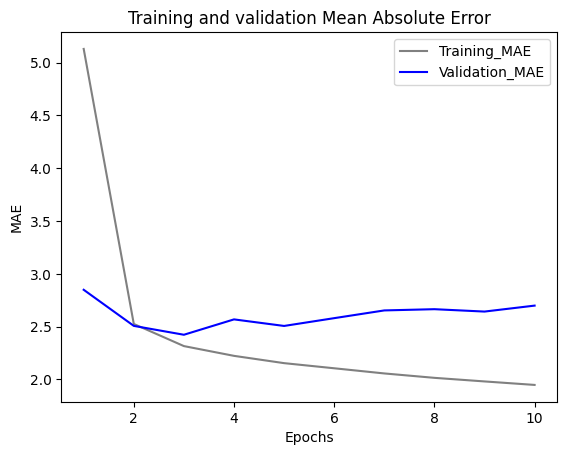

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **4.LSTM - Stacked(32 units)**

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(32, return_sequences=True)(inputs)
x = keras.layers.LSTM(32)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 146s 174ms/step - loss: 20.5383 - mae: 3.2628 - val_loss: 11.0137 - val_mae: 2.5751
Epoch 2/10
819/819 [==============================] - 142s 173ms/step - loss: 7.8731 - mae: 2.1949 - val_loss: 10.5518 - val_mae: 2.5518
Epoch 3/10
819/819 [==============================] - 144s 175ms/step - loss: 6.2213 - mae: 1.9442 - val_loss: 11.9652 - val_mae: 2.7143
Epoch 4/10
819/819 [==============================] - 146s 178ms/step - loss: 5.0927 - mae: 1.7577 - val_loss: 12.0576 - val_mae: 2.7190
Epoch 5/10
819/819 [==============================] - 145s 177ms/step - loss: 4.3405 - mae: 1.6184 - val_loss: 12.9145 - val_mae: 2.8319
Epoch 6/10
819/819 [==============================] - 139s 170ms/step - loss: 3.7212 - mae: 1.4962 - val_loss: 13.5343 - val_mae: 2.8989
Epoch 7/10
819/819 [==============================] - 150s 183ms/step - loss: 3.2625 - mae: 1.3980 - val_loss: 13.3283 - val_mae: 2.8959
Epoch 8/10
819/819 [====================

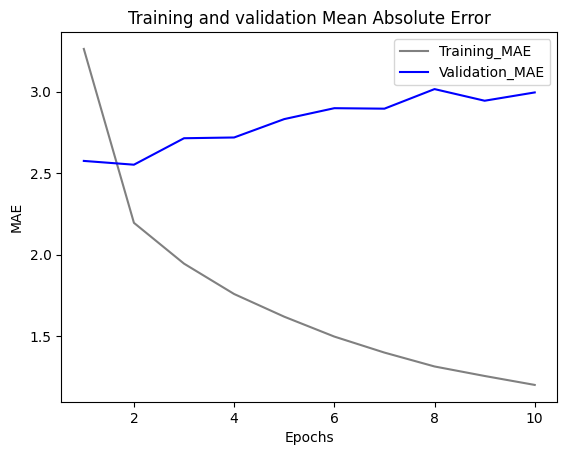

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **5.LSTM - Stacked(8 units)**

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(8, return_sequences=True)(inputs)
x = keras.layers.LSTM(8)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 73s 86ms/step - loss: 65.9435 - mae: 6.1847 - val_loss: 32.8525 - val_mae: 4.2304
Epoch 2/10
819/819 [==============================] - 77s 93ms/step - loss: 20.4566 - mae: 3.3564 - val_loss: 12.7617 - val_mae: 2.6892
Epoch 3/10
819/819 [==============================] - 72s 88ms/step - loss: 11.2639 - mae: 2.6059 - val_loss: 9.9383 - val_mae: 2.4411
Epoch 4/10
819/819 [==============================] - 71s 87ms/step - loss: 10.0800 - mae: 2.4773 - val_loss: 9.5197 - val_mae: 2.3900
Epoch 5/10
819/819 [==============================] - 75s 91ms/step - loss: 9.7548 - mae: 2.4376 - val_loss: 9.3016 - val_mae: 2.3697
Epoch 6/10
819/819 [==============================] - 73s 89ms/step - loss: 9.4442 - mae: 2.4012 - val_loss: 9.2440 - val_mae: 2.3617
Epoch 7/10
819/819 [==============================] - 71s 86ms/step - loss: 9.2763 - mae: 2.3805 - val_loss: 9.2944 - val_mae: 2.3705
Epoch 8/10
819/819 [==============================] - 74

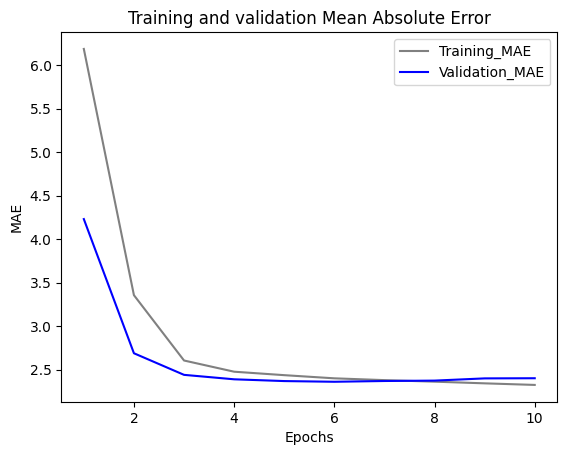

In [32]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **6.LSTM(dropout-regularized and stacked model)**

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = keras.layers.LSTM(8, recurrent_dropout=0.5)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 124s 146ms/step - loss: 83.8703 - mae: 7.1184 - val_loss: 43.2593 - val_mae: 4.9474
Epoch 2/10
819/819 [==============================] - 118s 144ms/step - loss: 34.9333 - mae: 4.4094 - val_loss: 15.3140 - val_mae: 2.8994
Epoch 3/10
819/819 [==============================] - 118s 144ms/step - loss: 24.7325 - mae: 3.7596 - val_loss: 11.0875 - val_mae: 2.5418
Epoch 4/10
819/819 [==============================] - 117s 142ms/step - loss: 22.7592 - mae: 3.6145 - val_loss: 10.2506 - val_mae: 2.4686
Epoch 5/10
819/819 [==============================] - 116s 142ms/step - loss: 21.3636 - mae: 3.5103 - val_loss: 10.1672 - val_mae: 2.4600
Epoch 6/10
819/819 [==============================] - 117s 143ms/step - loss: 20.2376 - mae: 3.4174 - val_loss: 9.8496 - val_mae: 2.4253
Epoch 7/10
819/819 [==============================] - 119s 145ms/step - loss: 19.3348 - mae: 3.3462 - val_loss: 9.3235 - val_mae: 2.3572
Epoch 8/10
819/819 [================

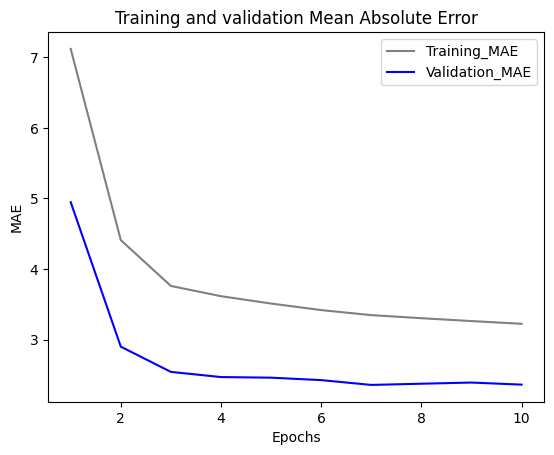

In [34]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **LSTM(Bidirectional )**

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.Bidirectional(keras.layers.LSTM(16))(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 59s 68ms/step - loss: 25.5146 - mae: 3.6324 - val_loss: 10.7102 - val_mae: 2.5354
Epoch 2/10
819/819 [==============================] - 56s 68ms/step - loss: 9.3612 - mae: 2.3834 - val_loss: 9.7244 - val_mae: 2.4060
Epoch 3/10
819/819 [==============================] - 56s 68ms/step - loss: 8.5867 - mae: 2.2791 - val_loss: 9.9514 - val_mae: 2.4377
Epoch 4/10
819/819 [==============================] - 56s 68ms/step - loss: 8.0994 - mae: 2.2152 - val_loss: 9.9498 - val_mae: 2.4382
Epoch 5/10
819/819 [==============================] - 56s 69ms/step - loss: 7.6575 - mae: 2.1564 - val_loss: 10.0222 - val_mae: 2.4520
Epoch 6/10
819/819 [==============================] - 55s 67ms/step - loss: 7.3419 - mae: 2.1126 - val_loss: 10.1167 - val_mae: 2.4602
Epoch 7/10
819/819 [==============================] - 55s 67ms/step - loss: 7.0709 - mae: 2.0743 - val_loss: 10.4408 - val_mae: 2.4998
Epoch 8/10
819/819 [==============================] - 56s

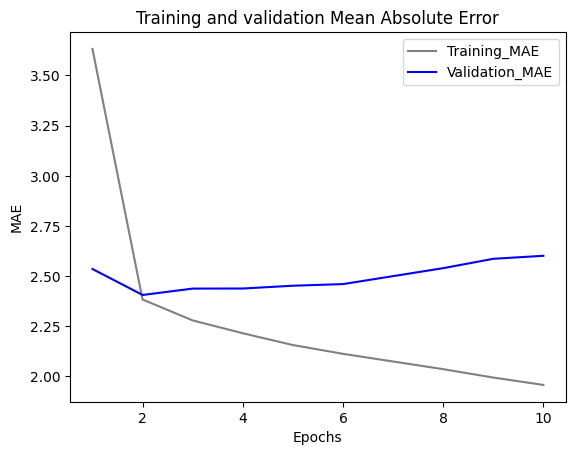

In [36]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **LSTM and 1D Convnets**

In [38]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.Conv1D(64, 3, activation='relu')(inputs)
x = keras.layers.MaxPooling1D(3)(x)
x = keras.layers.Conv1D(128, 3, activation='relu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = keras.layers.LSTM(16)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test_MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 16s 17ms/step - loss: 58.3045 - mae: 5.7475 - val_loss: 28.8645 - val_mae: 4.0910
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 18.8439 - mae: 3.3284 - val_loss: 21.2846 - val_mae: 3.6322
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 14.9626 - mae: 3.0004 - val_loss: 21.8787 - val_mae: 3.7433
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 13.3274 - mae: 2.8296 - val_loss: 21.2522 - val_mae: 3.6763
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 12.1143 - mae: 2.6942 - val_loss: 22.0994 - val_mae: 3.7108
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 11.1489 - mae: 2.5808 - val_loss: 24.4391 - val_mae: 3.8801
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 10.4105 - mae: 2.4912 - val_loss: 21.7840 - val_mae: 3.7384
Epoch 8/10
819/819 [============================

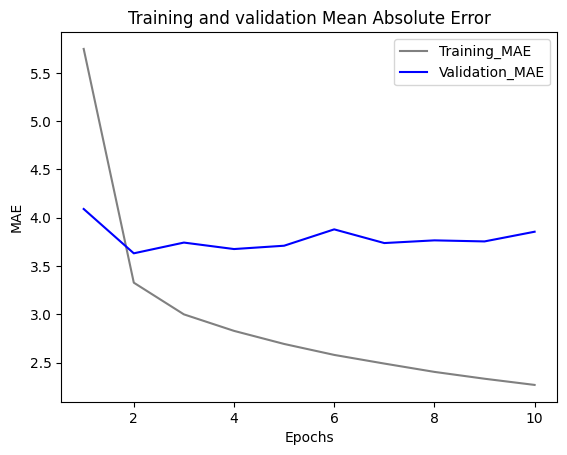

In [39]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="-", label="Training_MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="-", label="Validation_MAE")
plt.title("Training and validation Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

14 models were constructed : Here are the specifics:

**Model 1:** common-sense, non-machine-learning baseline

**Model 2:** A basic machine-learning model

**Model 3:** 1D convolutional model

**Model 4:** Simple RNN layer that can process sequences of any length

**Model 5:** Stacking RNN layers using simple RNN


**Model 6:** GRU (Gated Recurrent Unit)-Simple Method

**Model 7:** LSTM-Simple

**Model 8:** LSTM(dropout Regularization)

**Model 9:** LSTM Stacked(16 units)

**Model 10:** LSTM Stacked(32 units)

**Model 11:** LSTM Stacked(8 units)

**Model 12:** LSTM(dropout-regularized and stacked)

**Model 13:** LSTM(Bidirectional )

**Model 14:** LSTM and 1D Convnets

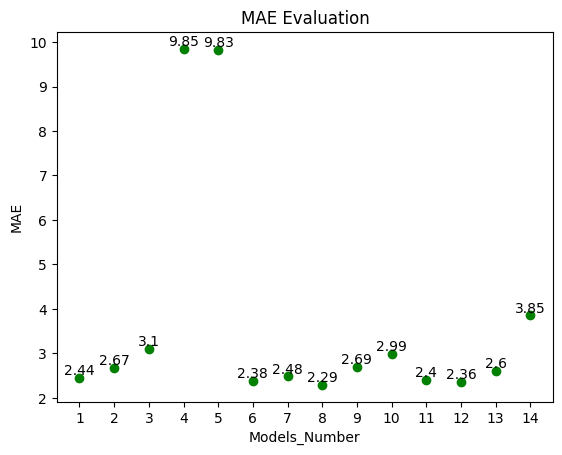

In [47]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.44,2.67,3.10,9.85,9.83,2.38,2.48,2.29,2.69,2.99,2.40,2.36,2.60,3.85)

##**Evaluation of  MAE Evaluation**##
plt.scatter(Models, Mae, color="green")
plt.title("MAE Evaluation")
plt.xlabel("Models_Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

